# Project 2 - Ames Housing Data and Kaggle Challenge

# 0.3 Data Analysis And Feature Engineering

# Table of contents

- [1.Load The Data](#1.-Load-The-Data)
- [2.Exploratory Data Analysis (EDA)](#2.-Exploratory-Data-Analysis-(EDA)])
- [3.Feature Engineering](#3.-Feature-Engineering])
- [4.Modeling](#4.-Modeling])

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm, probplot
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
%config IPCompleter.greedy=True

## 1.Load the Data

- Load both train and test data

In [2]:
train_df = pd.read_csv('../datasets/train_clean.csv')
test_df = pd.read_csv('../datasets/test_clean.csv')

In [3]:
train_df['saleprice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: saleprice, dtype: float64

## 2. Exploratory Data Analysis (EDA)

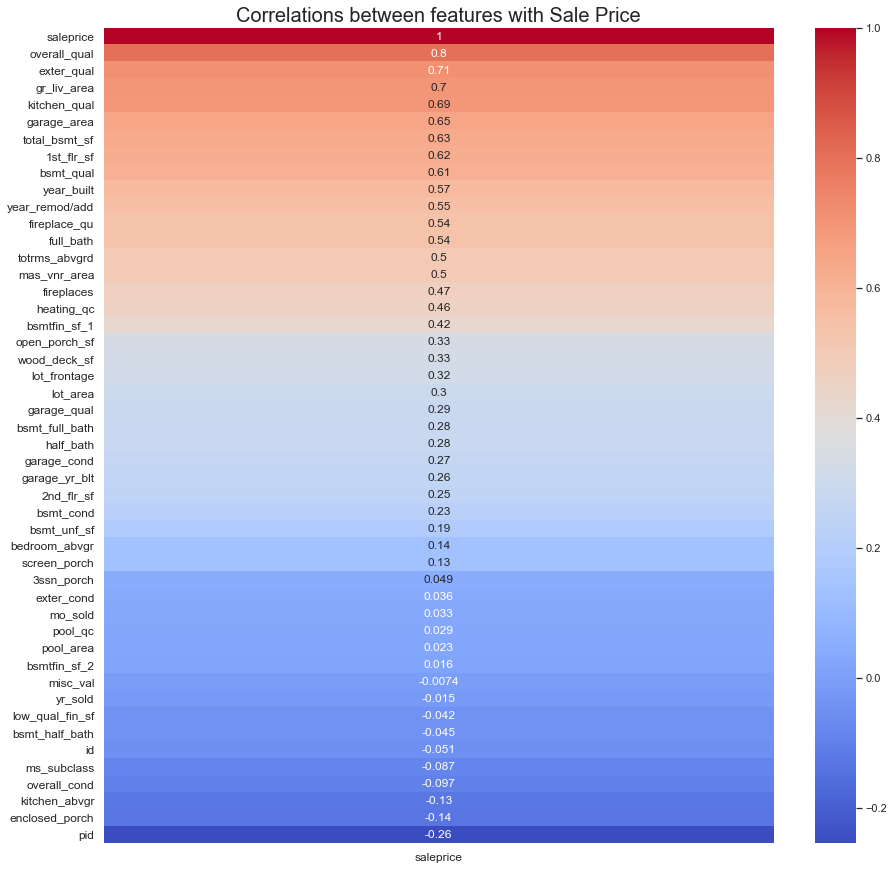

In [4]:
# Check correlation of each features with numeric variables with sale price

plt.figure(figsize = (15, 15))
sns.set(font_scale=1)

ax = sns.heatmap(train_df.corr()[['saleprice']].sort_values('saleprice', ascending=False), 
            cmap = 'coolwarm', 
            annot = True);

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)

plt.title(label = "Correlations between features with Sale Price", loc='center', fontsize = 20);

> As expected the overall quality of the house is the main factor which will affect the sale price which having the highest correlation with sale price, however there are few features are having multicolinearity so we can't just chose the top 5-10 features for out modeling. Check the multicollinear between features and evaluate again.

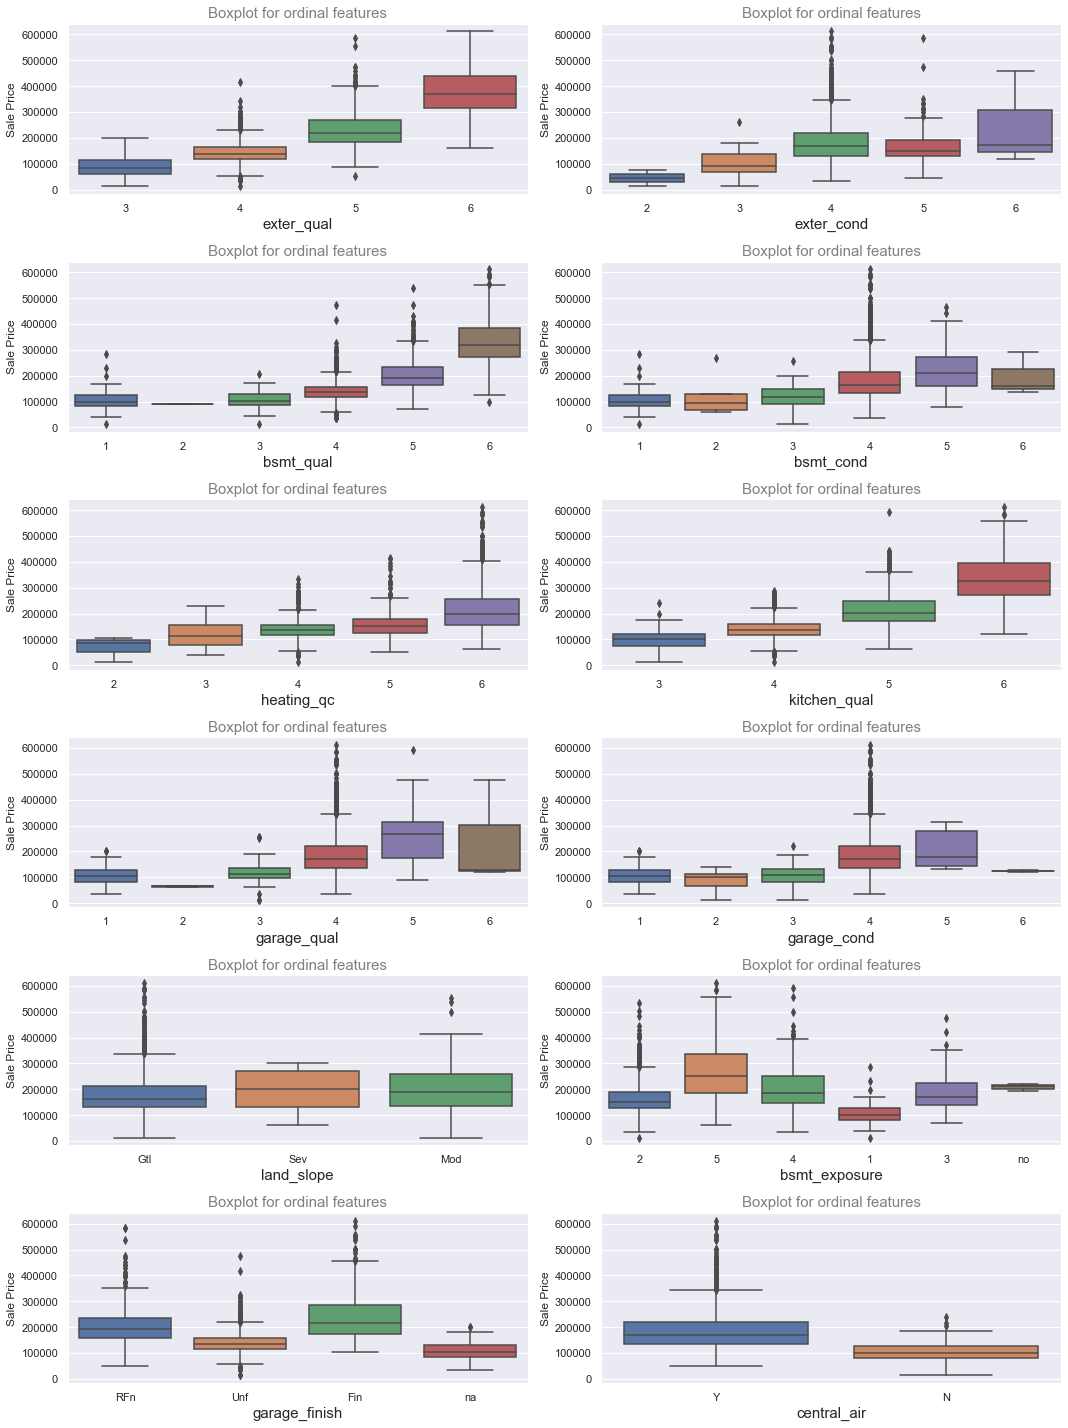

In [5]:
ordinal_cols = ['exter_qual','exter_cond','bsmt_qual','bsmt_cond','heating_qc','kitchen_qual',
                'garage_qual','garage_cond','land_slope','bsmt_exposure','garage_finish','central_air']


fig,ax =plt.subplots(nrows=6,ncols=2,figsize=(15,20))
ax= ax.ravel()   


for i, column in enumerate(ordinal_cols[0:]): # Gives us an index value to get into all our lists
        sns.boxplot(x=column, y='saleprice', data= train_df, orient= 'v', ax=ax[i]) 
        # Set titles, labels, etc here for each subplot
        ax[i].set_title('Boxplot for ordinal features',fontsize=15, fontweight=0, color='grey', loc='center')
        ax[i].set_xlabel(column, fontsize=15)
        ax[i].set_ylabel('Sale Price')

plt.tight_layout()
plt.show()

**Overall Quality**

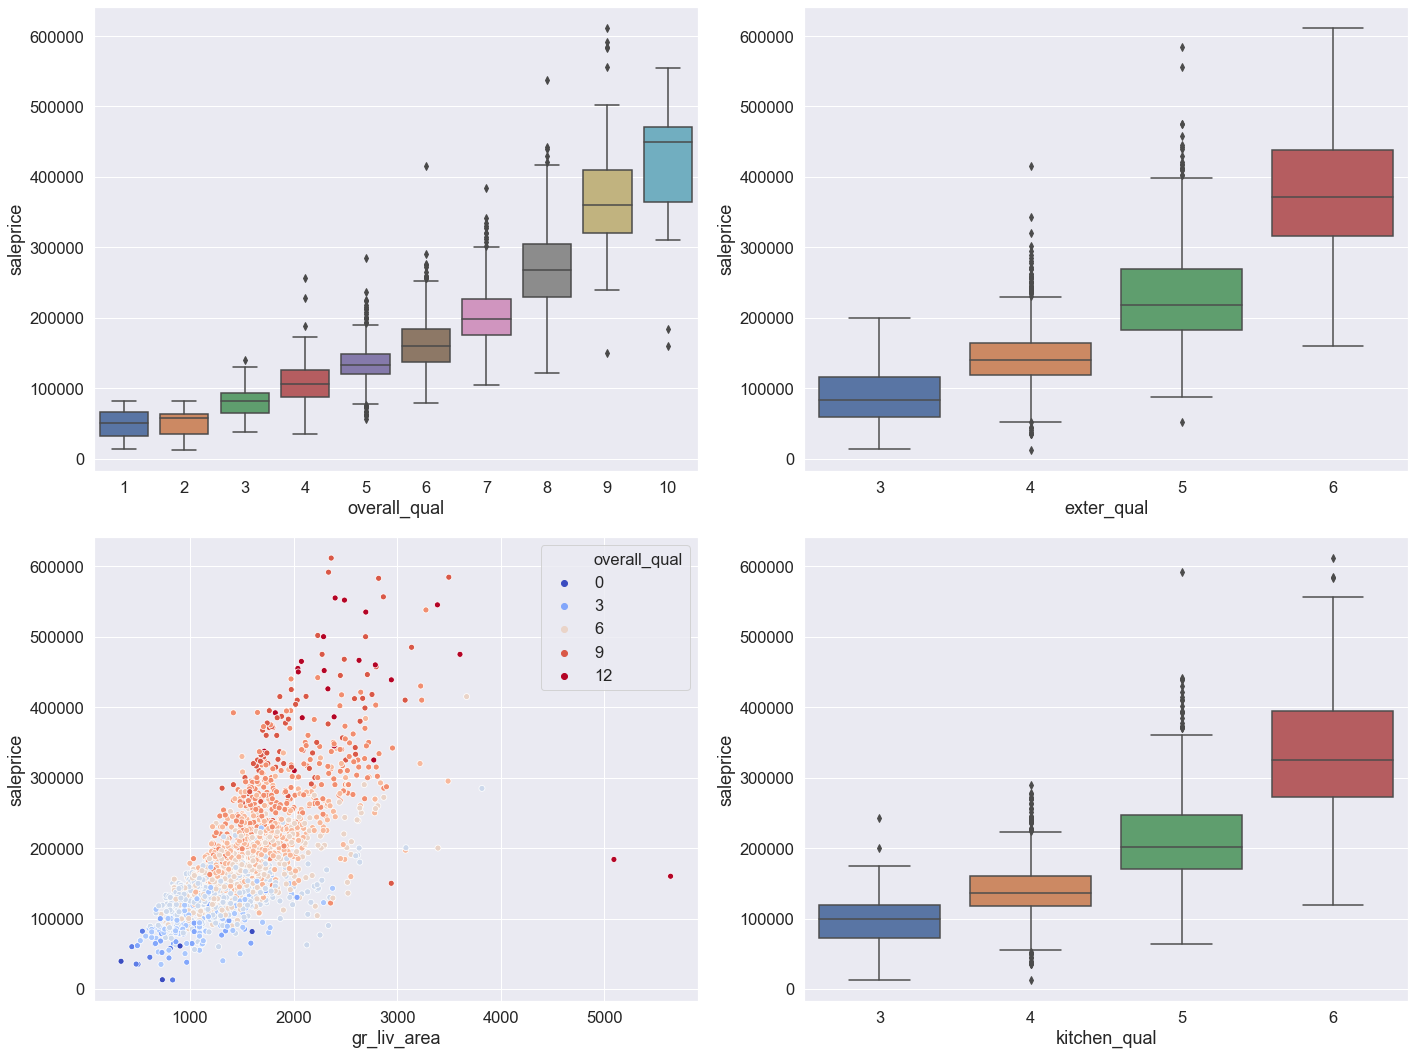

In [6]:
fig = plt.figure(figsize = (20,15))
sns.set(font_scale =1.5)

# (Corr= 0.8) Box plot overall_qual vs saleprice
plot1 = fig.add_subplot(221); sns.boxplot( x= 'overall_qual', y='saleprice', data= train_df[['saleprice','overall_qual']]);

# (Corr= 0.71) Box plot exter_qual vs saleprice
plot2 = fig.add_subplot(222); sns.boxplot( x= 'exter_qual', y='saleprice', data= train_df[['saleprice','exter_qual']]);

# (Corr= 0.7) Scatter plot gr_liv_area
plot3 = fig.add_subplot(223); sns.scatterplot(palette = 'coolwarm',hue=train_df['overall_qual'], x= 'gr_liv_area', y='saleprice', data= train_df[['saleprice','gr_liv_area']]);

# (Corr= 0.69) Scatter plot kitchen_qual
plot4 = fig.add_subplot(224); sns.boxplot(x= 'kitchen_qual', y='saleprice', data= train_df[['saleprice','kitchen_qual']]);

plt.tight_layout(); plt.show()

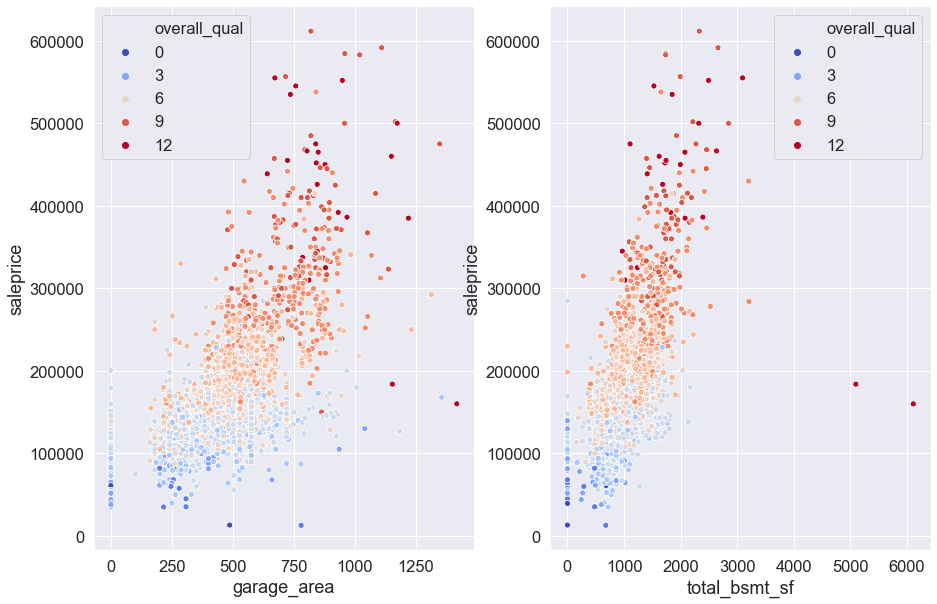

In [7]:
fig = plt.figure(figsize = (15,10))
sns.set(font_scale =1.5)

# (Corr= 0.65) Scatter plot garage_area
plt1 = fig.add_subplot(121); sns.scatterplot(palette = 'coolwarm',hue=train_df['overall_qual'], x= 'garage_area', y='saleprice', data= train_df[['saleprice','garage_area']]);

# (Corr= 0.63) Scatter plot total_bsmt_sf
plt2 = fig.add_subplot(122); sns.scatterplot(palette = 'coolwarm',hue=train_df['overall_qual'], x= 'total_bsmt_sf', y='saleprice', data= train_df[['saleprice','total_bsmt_sf']]);

From the graph above we can see the correlation is highly positve between features with high correlation with sale price. Notably there is 2 house which is outliers in gr_liv_area in each scatter plot.

**Bathroom**

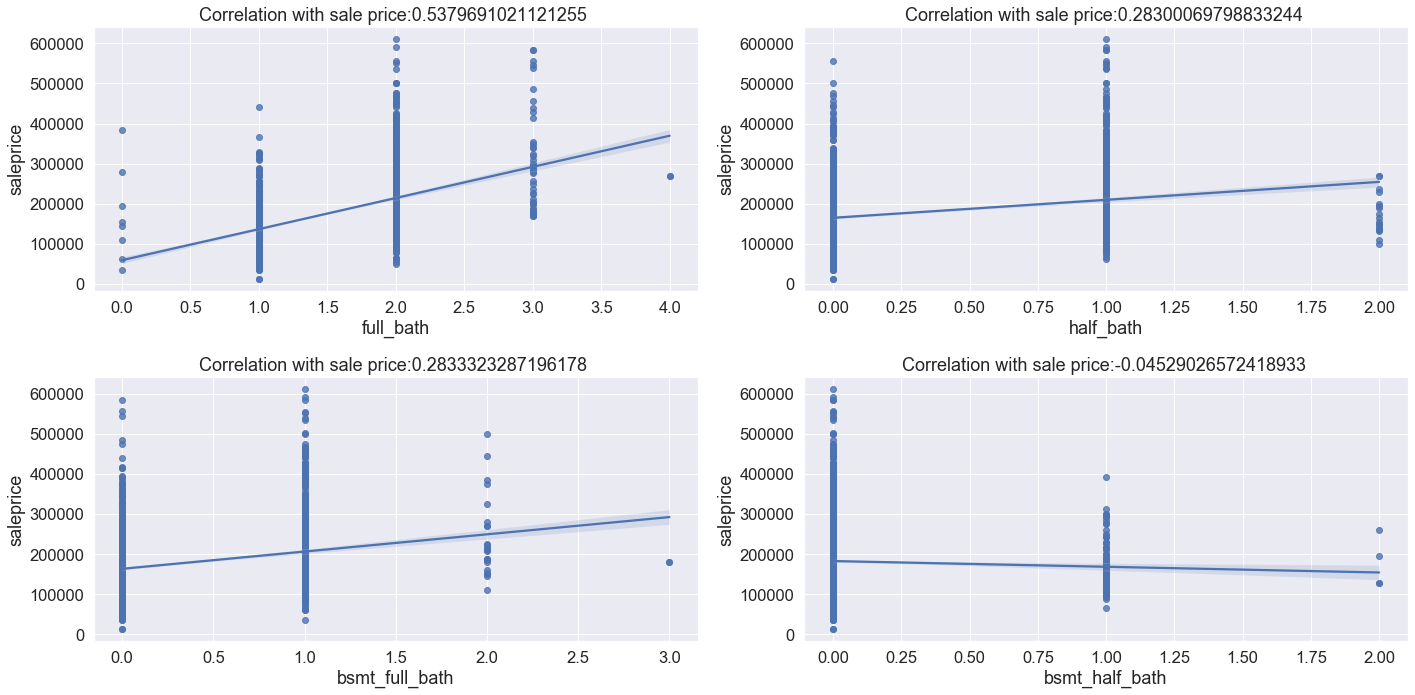

In [8]:
fig = plt.figure(figsize=(20,10))
sns.set(font_scale =1.5)
fig1 = fig.add_subplot(221); sns.regplot(x='full_bath', y='saleprice',data=train_df)
plt.title("Correlation with sale price:{} ".format(train_df.full_bath.corr(train_df['saleprice'])) );

fig2 = fig.add_subplot(222); sns.regplot(x='half_bath', y='saleprice',data=train_df)
plt.title("Correlation with sale price:{} ".format(train_df.half_bath.corr(train_df['saleprice'])) );

fig3 = fig.add_subplot(223); sns.regplot(x='bsmt_full_bath', y='saleprice',data=train_df)
plt.title("Correlation with sale price:{} ".format(train_df.bsmt_full_bath.corr(train_df['saleprice'])) );

fig4 = fig.add_subplot(224); sns.regplot(x='bsmt_half_bath', y='saleprice',data=train_df)
plt.title("Correlation with sale price:{} ".format(train_df.bsmt_half_bath.corr(train_df['saleprice'])) );

plt.tight_layout();plt.show()

The full_bath having highest correlation with sale price, other bath did not have strong correlation with sale price, however if i combine 4 of the bathrooms together it might be a stronger correlated with sale price, full bath as 1 half bath as 0.5.

**Basement SF**

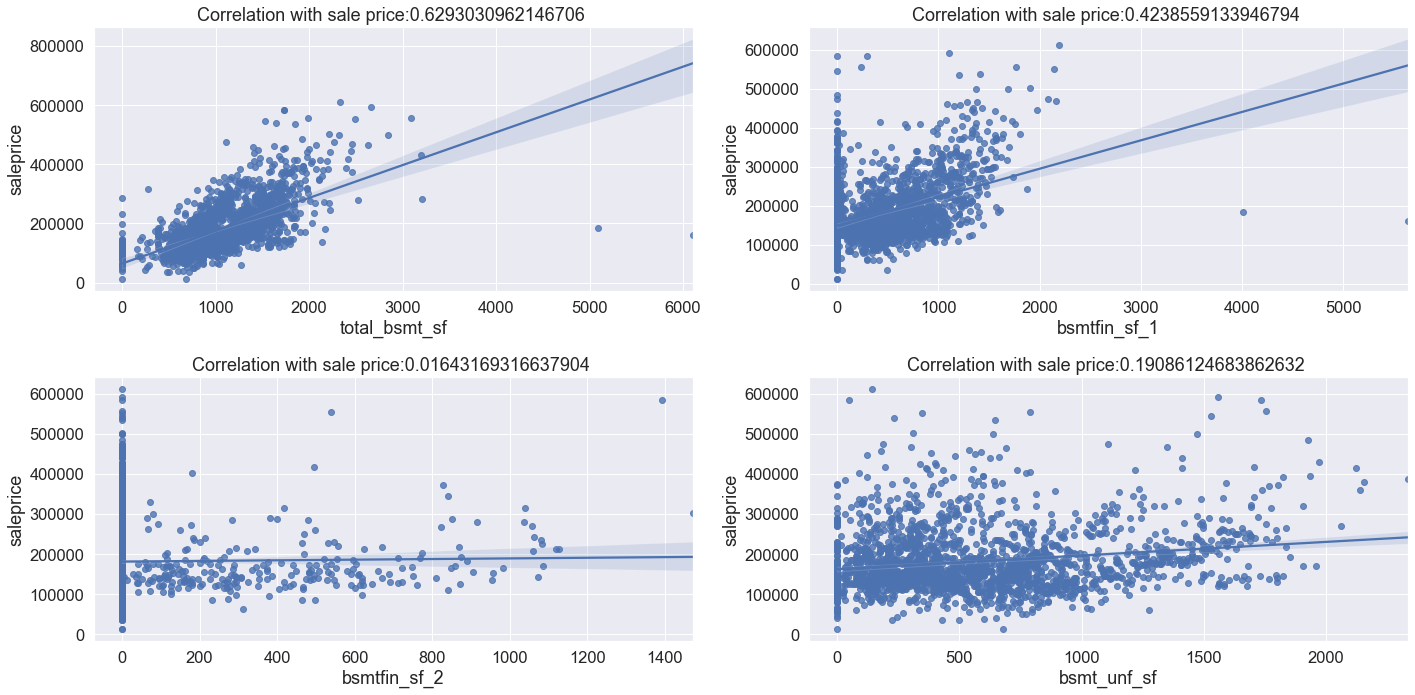

In [9]:
fig = plt.figure(figsize=(20,10))
sns.set(font_scale =1.5)
fig1 = fig.add_subplot(221); sns.regplot(x='total_bsmt_sf', y='saleprice',data=train_df)
plt.title("Correlation with sale price:{} ".format(train_df.total_bsmt_sf.corr(train_df['saleprice'])) );

fig2 = fig.add_subplot(222); sns.regplot(x='bsmtfin_sf_1', y='saleprice',data=train_df)
plt.title("Correlation with sale price:{} ".format(train_df.bsmtfin_sf_1.corr(train_df['saleprice'])) );

fig3 = fig.add_subplot(223); sns.regplot(x='bsmtfin_sf_2', y='saleprice',data=train_df)
plt.title("Correlation with sale price:{} ".format(train_df.bsmtfin_sf_2.corr(train_df['saleprice'])) );

fig4 = fig.add_subplot(224); sns.regplot(x='bsmt_unf_sf', y='saleprice',data=train_df)
plt.title("Correlation with sale price:{} ".format(train_df.bsmt_unf_sf.corr(train_df['saleprice'])) );

plt.tight_layout();plt.show()

Total basement square feet has the highest correlation, which is the sum of the bsmtfin_sf_1, bsmtfin_sf_2, bsmtfin_unf_sf.So by adding this 3 feature plot the scatter plot again to compare with total basement square feet.

**Neighborhood**

Let's see how the neighborhood might affect the pricing.

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


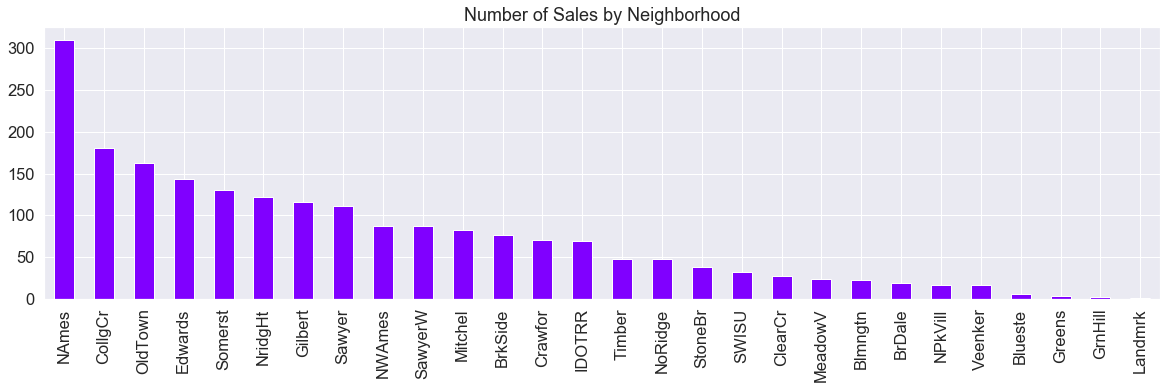

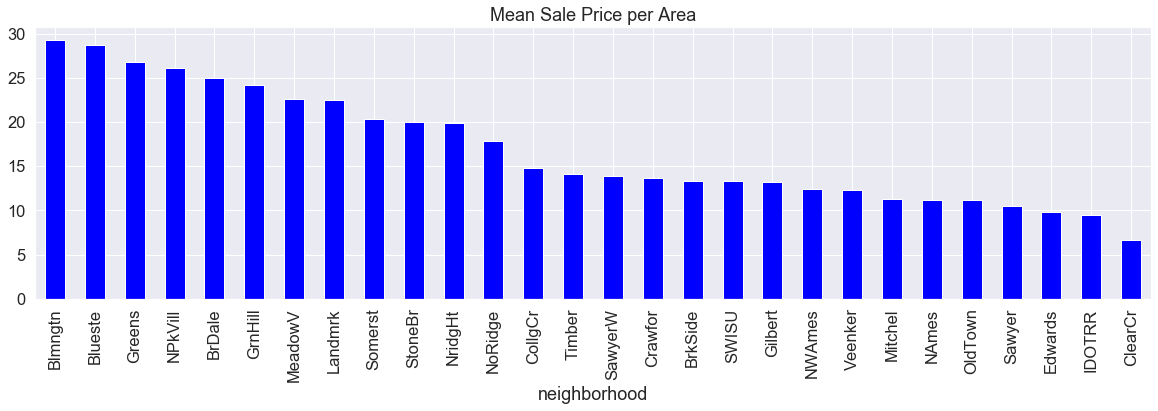

In [10]:
figa = plt.figure(figsize = (20,5))
g = train_df['neighborhood'].value_counts().plot(kind='bar', title= 'Number of Sales by Neighborhood', colormap='rainbow', stacked=True)

figb = plt.figure(figsize=(20,5))
plt.tight_layout()
df = train_df[['saleprice', 'yr_sold', 'neighborhood']]

df['totalarea'] = (train_df['total_bsmt_sf'] + train_df['wood_deck_sf'] + train_df['gr_liv_area'] + train_df['lot_area'] + train_df['mas_vnr_area'] + train_df['garage_area'] + train_df['open_porch_sf'] + train_df['3ssn_porch'] + train_df['screen_porch'] + train_df['enclosed_porch'] + train_df['pool_area'])

df = df.groupby(by= ['neighborhood','yr_sold'], as_index=False).sum()
neig = df[['saleprice','totalarea', 'neighborhood']].groupby(by='neighborhood', as_index = False).sum()
neig['neigprice'] = neig['saleprice'] / neig['totalarea']
neig.drop(['totalarea', 'saleprice'], axis=1, inplace = True)
g = neig.groupby('neighborhood')['neigprice'].sum().sort_values(ascending = False).\
    plot(kind='bar', title='Mean Sale Price per Area',colormap='brg',stacked =True)
neig = neig.groupby(by='neighborhood', as_index=True)['neigprice'].sum().sort_values(ascending=False)

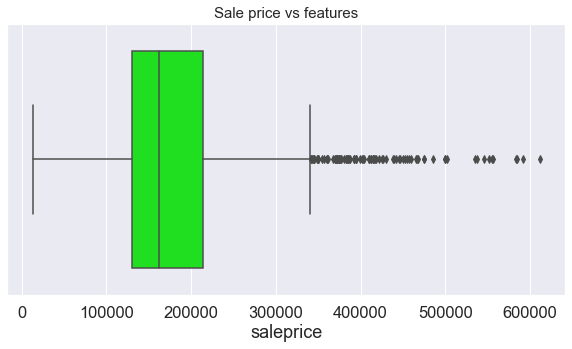

In [11]:
plt.figure(figsize = (10,5))
sns.boxplot('saleprice', data = train_df, color ='lime');

plt.title(label = "Sale price vs features", loc='center', fontsize = 15);

In [12]:
Q1 = 129825
Q3 = 214000
IQR = Q3 - Q1
upper = Q3 + (IQR*1.5)

print ('Upper Whisker {}'.format(upper))

Upper Whisker 340262.5


> There are outliers which house sale price higher than $340,262.50

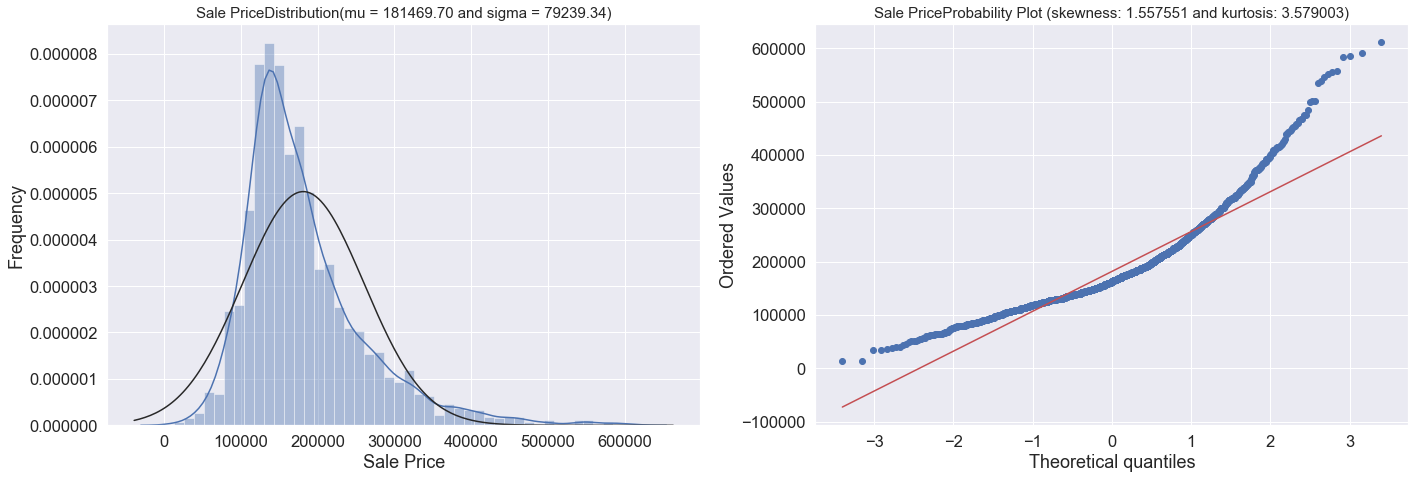

In [13]:
def sales_plot (data,measure):
    fig = plt.figure(figsize = (20,7))
    
    (mu,sigma) = norm.fit(data)
    
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    
    fig1.set_title(measure + "Distribution(mu = {:.2f} and sigma = {:.2f})".format(mu,sigma),loc='center', fontsize = 15)
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')
    
    fig2 = fig.add_subplot(122)
    res = probplot(data,plot=fig2)
    fig2.set_title(measure + "Probability Plot (skewness: {:.6f} and kurtosis: {:.6f})".format(data.skew(),data.kurt()),loc='center', fontsize = 15)
    
    plt.tight_layout()
    plt.show()
    
sales_plot(train_df.saleprice,'Sale Price')

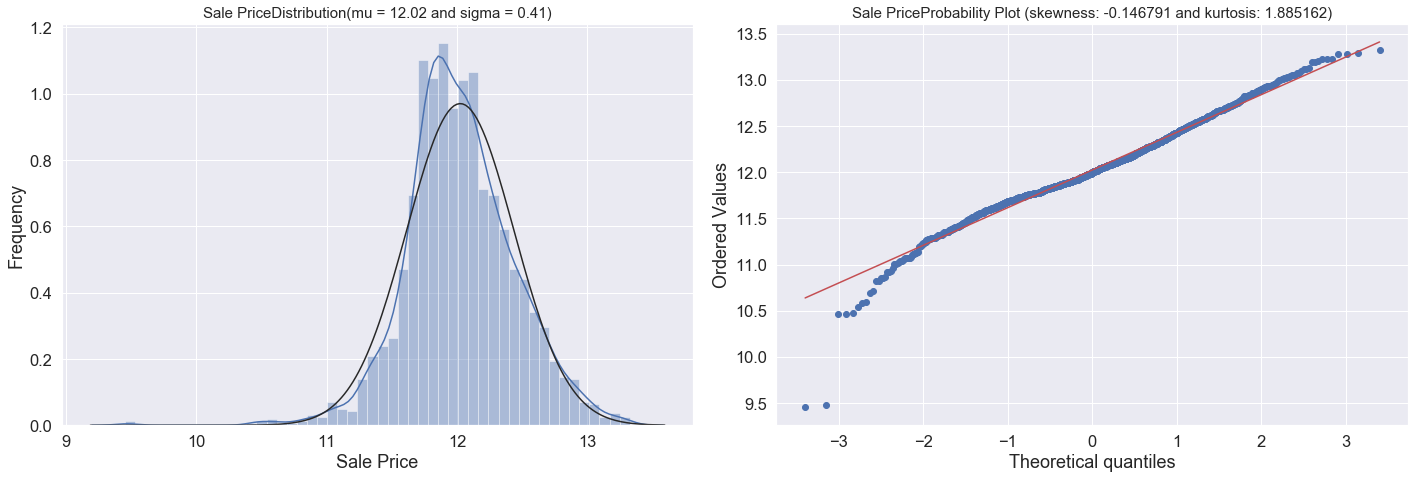

In [14]:
#Using log1P to see whether we can normalize the plot
train_df['saleprice'] = np.log1p(train_df['saleprice'])
ax = sales_plot(train_df.saleprice,'Sale Price')

> From the first graph above we can see that sale price distribution is skewed to the right, with a peak, deviates from normal distribution and positive biased. And from the probability plot, sale price also does not align with the linear line in read which represent normal distribtuion.<br>
<br>
Kurtosis is to measure either the data are heavily tailed or vice versa relative to normal distribution. This data sets tend tp havi high kurtosis having heavy tails, or identified as outliers.So 3.58 positive Kurtosis indicates a heavy tailed distribution which light tailed distribution will have negative Kurtosis values, there are outliers to be taken care of.

In [15]:
# check for multicollinearity between the features
# let 0.5 as the base of the multicollinearity

corr = train_df.corr()
base = 0.5
high_corr = corr[corr.abs() > base ][corr.abs() != 1].unstack().dropna().to_dict()
high_corr = pd.Series(high_corr, index = high_corr.keys())
high_corr = high_corr.reset_index()
high_corr = pd.DataFrame(high_corr)
high_corr.columns = ['feature_1', 'feature_2','correlation']
high_corr['correlation'] = high_corr['correlation'].drop_duplicates(keep ='first')
high_corr = high_corr.dropna().sort_values(by = 'correlation', ascending = False)

In [16]:
high_corr.head(30)

,feature_1,feature_2,correlation
91,garage_yr_blt,garage_cond,0.954885
100,garage_qual,garage_cond,0.950493
90,garage_yr_blt,garage_qual,0.947619
104,pool_area,pool_qc,0.904689
86,fireplaces,fireplace_qu,0.859734
10,overall_qual,saleprice,0.822775
64,gr_liv_area,totrms_abvgrd,0.813333
46,total_bsmt_sf,1st_flr_sf,0.808351
3,overall_qual,exter_qual,0.740257
29,exter_qual,kitchen_qual,0.730562


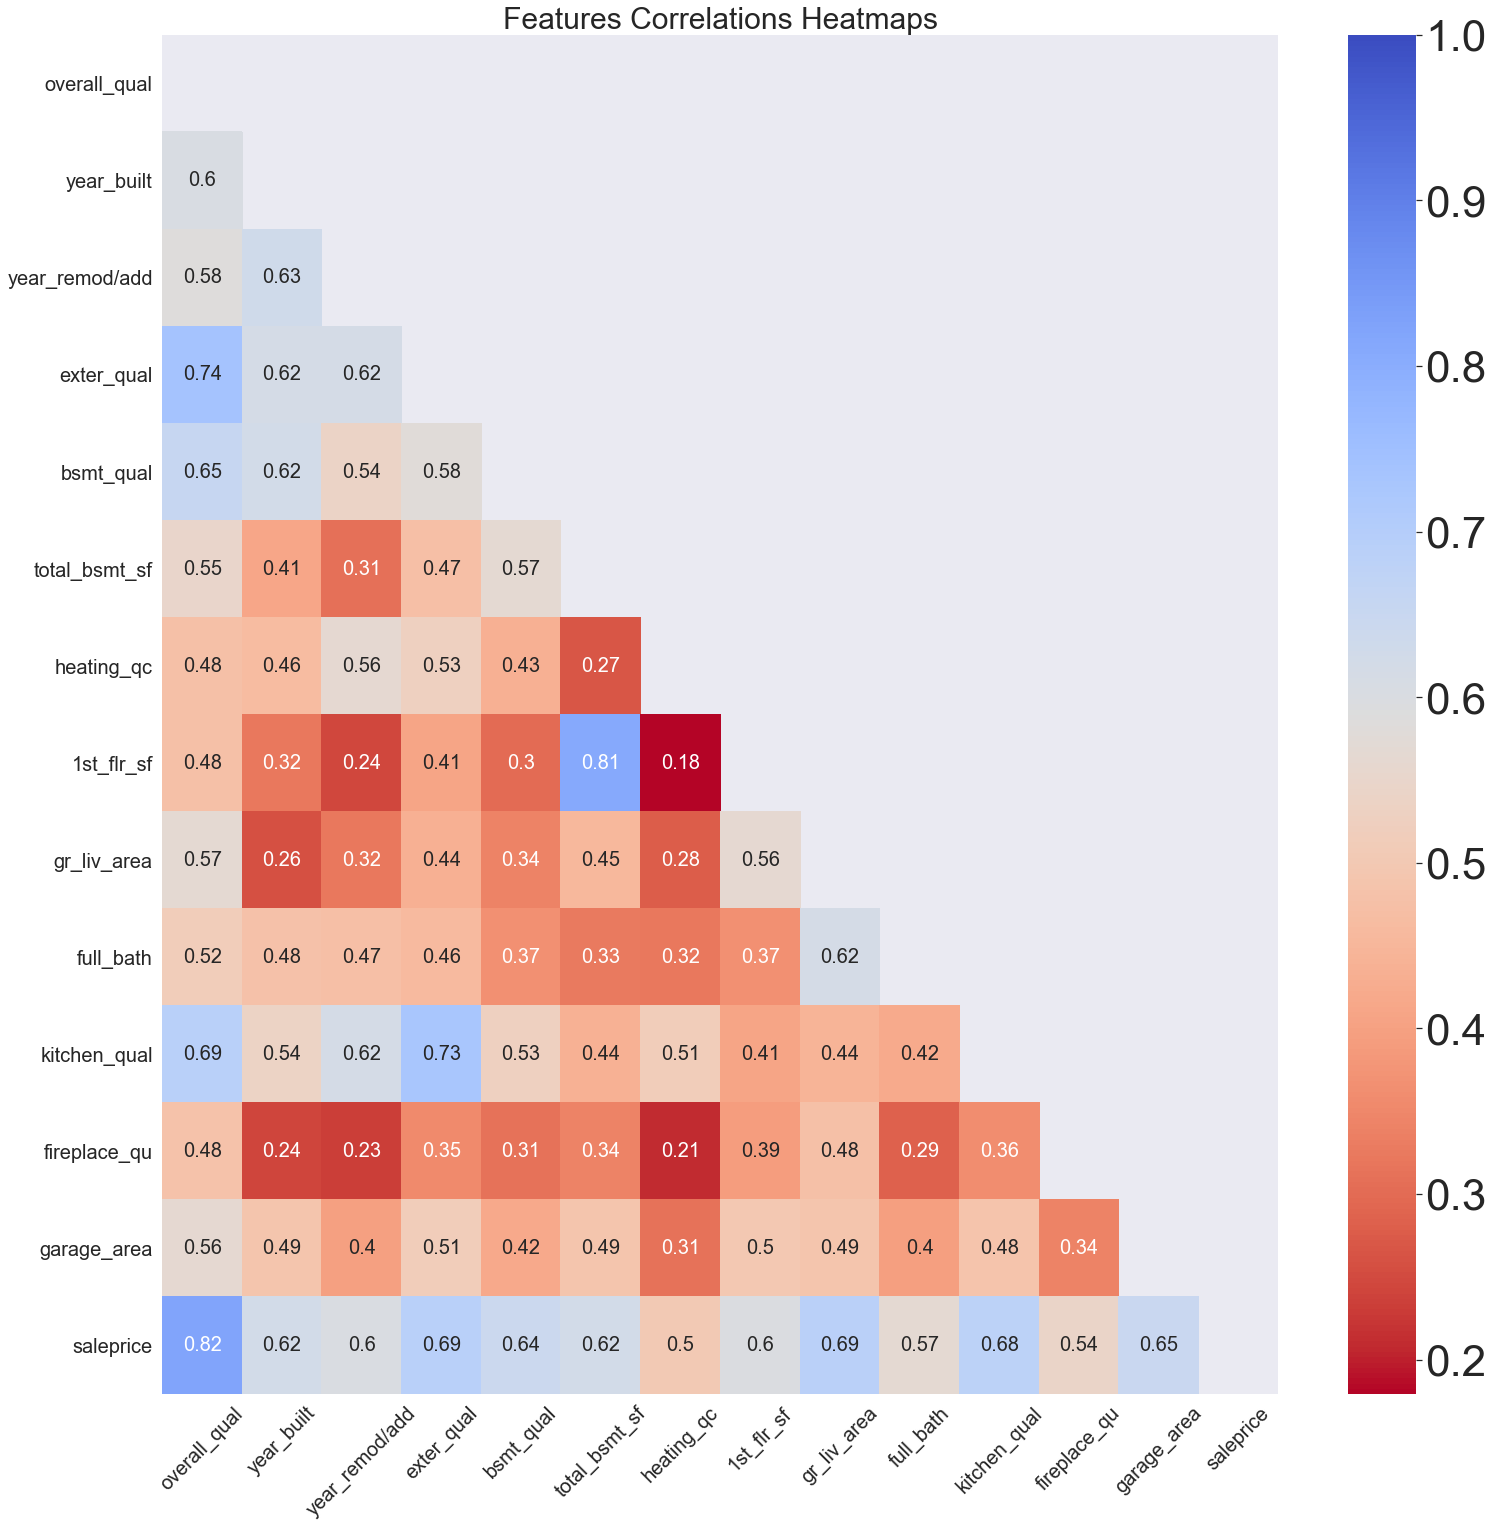

In [17]:
corr_map = train_df.corr()
best_features = corr_map.index[abs(corr_map["saleprice"])>0.5]

# Set the default matplotlib figure size to 20x14:
fix, ax = plt.subplots(figsize=(25,25))
sns.set(font_scale=4)

# Generate a mask for the upper triangle
mask = np.zeros_like(train_df[best_features].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns.
ax = sns.heatmap(train_df[best_features].corr(), mask=mask, ax=ax, cmap="coolwarm_r", annot=True,annot_kws={"size": 20})

# Resize and re-orientate the labels to improve the readability of the lables for each features.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=20)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.title(label = "Features Correlations Heatmaps", loc='center', fontsize = 30)
plt.show()

> Throught the collinearity matrix, there are many independent features that are highly correlated with each other, for example the garage cars and garage area are correlated, so other then garage area, the features related to garage will be dropped. 

## 3. Feature Engineering

**A. Dropping data multicolinearity**

In [18]:
train_df.drop(columns=['garage_yr_blt','garage_cond','garage_qual','heating_qc','pool_qc','fireplaces'],inplace=True)
test_df.drop(columns=['garage_yr_blt','garage_cond','garage_qual','heating_qc','pool_qc','fireplaces'],inplace=True)

**B. Combine features which are related**

In [19]:
# Bath rooms

#Train data
train_df['bath'] = train_df['full_bath'] + 0.5 * train_df['half_bath'] + train_df['bsmt_full_bath'] + 0.5 * train_df['bsmt_half_bath']

#Test data

test_df['bath'] = test_df['full_bath'] + 0.5 * test_df['half_bath'] + test_df['bsmt_full_bath'] + 0.5 * test_df['bsmt_half_bath']

In [20]:
# Basement area 1 and 2, unfinished area to be combined to catergorize as total basement area

#Train data
train_df['bsmt_sf'] = train_df['bsmtfin_sf_1'] + train_df['bsmtfin_sf_2'] + train_df['bsmt_unf_sf']

#Test data
test_df['bsmt_sf'] = test_df['bsmtfin_sf_1'] + test_df['bsmtfin_sf_2'] + test_df['bsmt_unf_sf']

In [21]:
# Properties age and properties remodeled age

#Train data
train_df['prop_age'] = train_df['yr_sold'] - train_df['year_built']
train_df['prop_remod'] = train_df['year_remod/add'] - train_df['year_built']

#Test data
test_df['prop_age'] = test_df['yr_sold'] - test_df['year_built']
test_df['prop_remod'] = test_df['year_remod/add'] - test_df['year_built']

In [22]:
train_df.drop(columns=['bsmt_full_bath','bsmt_half_bath','full_bath','half_bath','bsmtfin_sf_1','bsmtfin_sf_2','bsmt_unf_sf','yr_sold','year_built','year_remod/add','total_bsmt_sf'],inplace=True)
test_df.drop(columns=['bsmt_full_bath','bsmt_half_bath','full_bath','half_bath','bsmtfin_sf_1','bsmtfin_sf_2','bsmt_unf_sf','yr_sold','year_built','year_remod/add','total_bsmt_sf'],inplace=True)

In [23]:
sorted(train_df.corr().to_dict()['saleprice'].items(), key=lambda x: x[1], reverse=True)

[('saleprice', 1.0),
 ('overall_qual', 0.8227746215625452),
 ('exter_qual', 0.690334003357824),
 ('gr_liv_area', 0.6877749632505926),
 ('kitchen_qual', 0.6815508912823289),
 ('bath', 0.6593410628145956),
 ('garage_area', 0.6502439109638773),
 ('bsmt_qual', 0.6420611736687015),
 ('bsmt_sf', 0.6221626083072771),
 ('1st_flr_sf', 0.5990866779035441),
 ('fireplace_qu', 0.5420441263452964),
 ('totrms_abvgrd', 0.4965020811594141),
 ('mas_vnr_area', 0.44210673171548326),
 ('wood_deck_sf', 0.33014554429653925),
 ('open_porch_sf', 0.3282686701423804),
 ('lot_frontage', 0.31360852554356067),
 ('bsmt_cond', 0.2943379162848924),
 ('lot_area', 0.279942235274496),
 ('2nd_flr_sf', 0.2567716784677947),
 ('bedroom_abvgr', 0.17573718175305347),
 ('screen_porch', 0.12598292465456581),
 ('exter_cond', 0.087083457982923),
 ('3ssn_porch', 0.054917961076629745),
 ('mo_sold', 0.03139619809573409),
 ('pool_area', 0.029989714655212146),
 ('misc_val', 0.0006366211886671376),
 ('overall_cond', -0.03709834937737272

In [24]:
features_num = list(train_df._get_numeric_data().drop(['ms_subclass', 'mo_sold', 'saleprice'], axis=1))
features_cat = [x for x in train_df.columns if (x not in features_num) and (x != 'saleprice')]

In [25]:
train_df['ms_subclass'] = train_df['ms_subclass'].astype(str)
train_df['mo_sold'] = train_df['mo_sold'].astype(str)

test_df['ms_subclass'] = test_df['ms_subclass'].astype(str)
test_df['mo_sold'] = test_df['mo_sold'].astype(str)

**C.Create dummy variables**

In [26]:
train_df = pd.get_dummies(train_df, columns=features_cat, drop_first=True)

In [27]:
#check the train dataframe shape
train_df.shape

(2051, 250)

In [28]:
#select the features which except saleprice
features_model = [x for x in train_df.columns if x != 'saleprice']

In [29]:
#create dummy for test data frame
test_df = pd.get_dummies(test_df, columns=features_cat, drop_first=True)

In [30]:
# the test dataframe shape
test_df.shape

(879, 230)

In [31]:
# there were 19 column missing, so write a function to fit the missing coluns into test data frame.
missing_col = set(train_df.columns) - set(test_df.columns)

for x in missing_col:
    test_df[x] = 0
test_df = test_df[features_model]

**D. Split data into train and test set**

In [32]:
X = train_df[features_model]
#inverse the sale price from log1p
y = np.expm1(train_df['saleprice'])
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42,
                                                    test_size=0.05)

In [33]:
test_df.shape

(879, 249)

## 4. Modeling

Once EDA done, now we can use training data to build a model to predict the house price with the features selected. So in modeling we will use Linear Regressiom, Lasso, Ridge.

**A. Baseline Score**

In [34]:
lasso = LassoCV()

In [35]:
cross_val_score(lasso, X_train, y_train, cv=10).mean()

0.061315988453846594

In [36]:
# fit lasso using training set
lasso.fit(X_train,y_train)
# training score
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
# testing score
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.07
Test set score: 0.06
Number of features used: 1


The baseline cross val score seems very low, in order to improve the score, instantiate StandardScaler to scale the data.

In [37]:
X = train_df[features_model]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42,
                                                    test_size=0.05)

In [39]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [40]:
base_pred = pd.DataFrame(np.full(len(y_test),y.mean()))
base_pred.mean()

0    181469.701609
dtype: float64

**B. Lasso**

In [41]:
round(cross_val_score(lasso, X_train_sc, y_train, cv=10).mean(),4)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 963462575.3486328, tolerance: 876905551.1961133
  tol, rng, random, positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1106507185.2680664, tolerance: 876905551.1961133
  tol, rng, random, positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1091058468.5402832, tolerance: 876905551.1961133
  tol, rng, random, positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

0.8595

In [42]:
lasso.coef_.mean()

-4.298574641387627e-07

In [43]:
# fit lasso using training set
model_lasso = lasso.fit(X_train_sc,y_train)
# training score
print("Training set score: {:.2f}".format(lasso.score(X_train_sc, y_train)))
# testing score
print("Test set score: {:.2f}".format(lasso.score(X_test_sc, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1103075386.0769043, tolerance: 938293460.6046075
  tol, rng, random, positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1084524319.2260742, tolerance: 938293460.6046075
  tol, rng, random, positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1039544443.854248, tolerance: 938293460.6046075
  tol, rng, random, positive)


Training set score: 0.90
Test set score: 0.89
Number of features used: 89


Fit lasso model into RFE to narrow down the features into 40

In [44]:
# feature extraction
rfe = RFE(lasso,n_features_to_select=40)
rfe_fit = rfe.fit(X_train_sc,y_train)
# print("Num Features: %d" % rfe_fit.n_features_)
# print("Selected Features: %s" % rfe_fit.support_)
# print("Feature Ranking: %s" % rfe_fit.ranking_)
dfsupport = pd.DataFrame(rfe_fit.support_)
dfranking = pd.DataFrame(rfe_fit.ranking_)
dfcolumns = pd.DataFrame(X.columns)
# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfsupport,dfranking],axis=1)
# naming the dataframe columns
featureScores.columns = ['Feature','Selection','Rank']

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1103075386.0769043, tolerance: 938293460.6046075
  tol, rng, random, positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1084524319.2260742, tolerance: 938293460.6046075
  tol, rng, random, positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1039544443.854248, tolerance: 938293460.6046075
  tol, rng, random, positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1091234430.2642822, tolerance: 938293460.6046075
  tol, rng, random, positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1062022583.0415039, tolerance: 938293460.6046075
  tol, rng, random, positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1016387671.2001953, tolerance: 938293460.6046075
  tol, rng, random, positive)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might

In [80]:
top_40 = featureScores.loc[featureScores['Selection']==True]
best_feature = [i for i in top_40['Feature']]

In [46]:
X = train_df[best_feature]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42,
                                                    test_size=0.05)

In [48]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [49]:
cross_val_score(lasso, X_train_sc, y_train, cv=10).mean()

0.868538662278528

In [50]:
# fit lasso using training set
model_lasso = lasso.fit(X_train_sc,y_train)
# training score
print("Training set score: {:.2f}".format(lasso.score(X_train_sc, y_train)))
# testing score
print("Test set score: {:.2f}".format(lasso.score(X_test_sc, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.90
Test set score: 0.89
Number of features used: 40


Now the score improved alot comparing to the baseline Lasso model.

In [51]:
lasso.intercept_

181329.39219712527

In [52]:
pred_lasso = lasso.predict(X_test)

In [53]:
pred_lasso.mean()

66598040.71422249

**C. Linear Regression**

In [54]:
lr = LinearRegression()

In [55]:
round(cross_val_score(lr, X_train_sc, y_train, cv=10).mean(),4)

0.8688

In [56]:
# fit linear using training set
model_lr = lr.fit(X_train_sc,y_train)
# training score
print("Training set score: {:.2f}".format(lr.score(X_train_sc, y_train)))
# testing score
print("Test set score: {:.2f}".format(lr.score(X_test_sc, y_test)))
print("Number of features used: {}".format(np.sum(lr.coef_ != 0)))

Training set score: 0.90
Test set score: 0.89
Number of features used: 40


The linear regression model score is low because the linear regression model did not able to lower the coeffcient of the feature to 0, so total of 249 features were chosed which causing the cross validation score to be low.

In [57]:
lr.intercept_

181329.39219712527

In [58]:
pred_lr = lr.predict(X_test)

In [59]:
pred_lr.mean()

66803278.029581934

**D. Ridge**

In [60]:
ridge = RidgeCV()

In [61]:
round(cross_val_score(ridge, X_train_sc, y_train, cv=5).mean(),4)

0.8669

In [62]:
# fit ridge using training set
model_ridge = ridge.fit(X_train_sc,y_train)
# training score
print("Training set score: {}".format(ridge.score(X_train_sc, y_train)))
# testing score
print("Test set score: {}".format(ridge.score(X_test_sc, y_test)))
print("Number of features used: {}".format(np.sum(ridge.coef_ != 0)))

Training set score: 0.8989639742971433
Test set score: 0.89173670913616
Number of features used: 40


Ridge cross validation score seems better than linear regression model, however it is still not good enough to match with Lasso model.So we will proceed to use Lasso as predictor model.

In [63]:
ridge.intercept_

181329.39219712527

In [64]:
pred_ridge = ridge.predict(X_test)

In [65]:
pred_ridge.mean()

66487113.903764

**E. Modeling and Price Predictor With Test Data**

In [66]:
test_df = pd.read_csv('../datasets/test_clean.csv')

In [67]:
categorical_test = [i for i in test_df if test_df[i].dtype == 'O']

In [68]:
cat_feature_test = test_df[categorical_test]

In [69]:
cat_features_test = pd.concat([pd.get_dummies(test_df[feat],prefix=feat) for feat in test_df if test_df[feat].dtype == 'O'], axis=1)

In [70]:
cont_features_test = test_df.select_dtypes(exclude=['object'])

In [71]:
test_df= pd.concat([cont_features_test,cat_features_test],axis=1)

In [72]:
missing_col = set(train_df.columns) - set(test_df.columns)

for x in missing_col:
    test_df[x] = 0
test_df = test_df[features_model]

In [73]:
ss = StandardScaler()
X = ss.fit_transform(test_df[best_feature])

In [74]:
prediction = model_lasso.predict(X)

In [75]:
base_pred.mean()

0    181469.701609
dtype: float64

In [76]:
prediction.mean()

181329.39219712527

**F. Export Predicted Price**

In [77]:
# For Kaggle Submission
submission = pd.DataFrame()
submission['Id'] = test_df['id']
submission['SalePrice'] = prediction
submission.head()

,Id,SalePrice
0,2658,152669.725609
1,2718,154696.973095
2,2414,207039.661073
3,1989,140974.967770
4,625,189606.201654


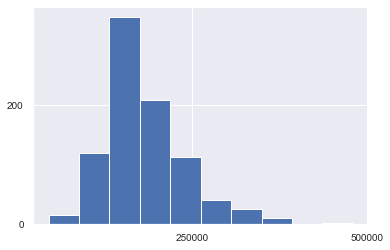

In [78]:
submission['SalePrice'].hist(xlabelsize=10,ylabelsize=10);

In [79]:
submission.to_csv('../datasets/submission_r1.csv',index=False)

Kaggle Submission Score, RMSE : 38915.66